In [2]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

from langgraph.graph import START, END, StateGraph, add_messages, MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, RemoveMessage
from langchain_core.runnables import Runnable
from collections.abc import Sequence
from typing import Literal, Annotated

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The mypy_ipython extension is already loaded. To reload it, use:
  %reload_ext mypy_ipython


In [2]:
class State(TypedDict):
    messages: Sequence[BaseMessage]

In [50]:
def ask_q(state: State) -> State:
    print("What is your question?")
    print(f"state: {state}")
    return State(messages=[HumanMessage(input())])

In [51]:
def chatbot(state:State) -> State:
    res = llm.invoke(state["messages"])
    print(f"state: {state}")
    return State(messages=[res])

In [64]:
def ask_another_q(state:State) -> State:
    print(f"state: {state}")
    print("Do you have another question? (yes/no)")
    return State(messages=[HumanMessage(input().strip().lower())])   # yes/no を返すだけ

In [65]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    api_version="2025-01-01-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=6
)

In [66]:
state = State(messages=[HumanMessage("Could you tell me why birds can fly?")])
ask_q(state)

What is your question?
state: {'messages': [HumanMessage(content='Could you tell me why birds can fly?', additional_kwargs={}, response_metadata={})]}


{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={})]}

In [67]:
# 次の質問も聞くか確認するだけの関数
def routing_func(state:State) -> bool:
    print(f"state: {state}")

    return state["messages"][0].content == "yes"

In [68]:
graph = StateGraph(State)

graph.add_node("ask_q", ask_q)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_q", ask_another_q)

graph.add_edge(START, "ask_q")
graph.add_edge("ask_q", "chatbot")
graph.add_edge("chatbot", "ask_another_q")
graph.add_conditional_edges(source="ask_another_q", path=routing_func, path_map={True:"ask_q", False:"__end__"})

graph_compiled = graph.compile()

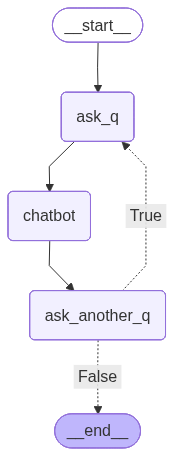

In [69]:
graph_compiled

In [70]:
graph_compiled.invoke(State(messages=[]))

What is your question?
state: {'messages': []}
state: {'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]}
state: {'messages': [AIMessage(content='Hello! 😊 How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 8, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C8R8tqIzpdVbx9O8UI7HOSYzbj3Zr', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {

{'messages': [HumanMessage(content='no', additional_kwargs={}, response_metadata={})]}